In [88]:
# !pip install Basemap

In [89]:
# !pip install imread

In [90]:
# !pip install tensorboard

In [91]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import numpy as np
plt.style.use('fivethirtyeight')
import warnings
from keras.callbacks import TensorBoard
warnings.filterwarnings('ignore')
import datetime
import holidays
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.metrics import mean_squared_error
from math import sqrt


In [92]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [93]:
tdf=pd.read_csv("/content/drive/My Drive/Colab Notebooks/OR_610_Project/globalterrorismdb_0617dist.csv", encoding='ISO-8859-1')
tdf.rename(columns={'iyear':'Year','imonth':'Month','iday':'Day','country_txt':'Country','region_txt':'Region','attacktype1_txt':'AttackType','target1':'Target','nkill':'Killed','nwound':'Wounded','summary':'Summary','gname':'Group','targtype1_txt':'Target_type','weaptype1_txt':'Weapon_type','motive':'Motive'},inplace=True)
tdf.fillna({'Killed': tdf['Killed'].median(), 'Wounded': tdf['Wounded'].median()}, inplace=True)
tdf['casualties']= tdf['Killed']+ tdf['Wounded']
tdf['Weapon_type'] = tdf['Weapon_type'].replace({'Vehicle (not to include vehicle-borne explosives, i.e., car or truck bombs)': 'Vehicle'})

tdf.head(5)

,eventid,Year,Month,Day,approxdate,extended,resolution,country,Country,region,...,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related,casualties
0,197000000001,1970,7,2,NaN,0,NaN,58,Dominican Republic,2,...,NaN,NaN,NaN,PGIS,0,0,0,0,NaN,1.0
1,197000000002,1970,0,0,NaN,0,NaN,130,Mexico,1,...,NaN,NaN,NaN,PGIS,0,1,1,1,NaN,0.0
2,197001000001,1970,1,0,NaN,0,NaN,160,Philippines,5,...,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN,1.0
3,197001000002,1970,1,0,NaN,0,NaN,78,Greece,8,...,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN,0.0
4,197001000003,1970,1,0,NaN,0,NaN,101,Japan,4,...,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN,0.0


In [94]:
tdf['Year'] = tdf['Year'].astype(str)
tdf['Month'] = tdf['Month'].astype(str)
tdf['Day'] = tdf['Day'].astype(str)

In [95]:
tdf['Month'] = tdf['Month'].str.pad(width=2, fillchar='0')
tdf['Day'] = tdf['Day'].str.pad(width=2, fillchar='0')
tdf['Month'] = tdf['Month'].replace({'00':'01'})
tdf['Day'] = tdf['Day'].replace({'00':'01'})
tdf['Date'] = tdf[['Year', 'Month', 'Day']].apply(lambda x: '-'.join(x), axis=1)

tdf = tdf.sort_values(by='Date')
tdf.head(10)

,eventid,Year,Month,Day,approxdate,extended,resolution,country,Country,region,...,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related,casualties,Date
1,197000000002,1970,01,01,NaN,0,NaN,130,Mexico,1,...,NaN,NaN,PGIS,0,1,1,1,NaN,0.0,1970-01-01
2,197001000001,1970,01,01,NaN,0,NaN,160,Philippines,5,...,NaN,NaN,PGIS,-9,-9,1,1,NaN,1.0,1970-01-01
3,197001000002,1970,01,01,NaN,0,NaN,78,Greece,8,...,NaN,NaN,PGIS,-9,-9,1,1,NaN,0.0,1970-01-01
4,197001000003,1970,01,01,NaN,0,NaN,101,Japan,4,...,NaN,NaN,PGIS,-9,-9,1,1,NaN,0.0,1970-01-01
5,197001010002,1970,01,01,NaN,0,NaN,217,United States,1,...,"""Cairo Police Chief Quits; Decries Local 'Mili...","Christopher Hewitt, ""Political Violence and Te...",Hewitt Project,-9,-9,0,-9,NaN,0.0,1970-01-01
10,197001050001,1970,01,01,NaN,0,NaN,217,United States,1,...,NaN,NaN,PGIS,0,0,0,0,NaN,0.0,1970-01-01
8,197001020003,1970,01,02,NaN,0,NaN,217,United States,1,...,"David Newman, Sandra Sutherland, and Jon Stewa...","The Wisconsin Cartographers' Guild, ""Wisconsin...",Hewitt Project,0,0,0,0,NaN,0.0,1970-01-02
6,197001020001,1970,01,02,NaN,0,NaN,218,Uruguay,3,...,NaN,NaN,PGIS,0,0,0,0,NaN,0.0,1970-01-02
7,197001020002,1970,01,02,NaN,0,NaN,217,United States,1,...,"Christopher Hewitt, ""Political Violence and Te...",NaN,Hewitt Project,-9,-9,0,-9,NaN,0.0,1970-01-02
9,197001030001,1970,01,03,NaN,0,NaN,217,United States,1,...,"Tom Bates, ""Rads: The 1970 Bombing of the Army...","David Newman, Sandra Sutherland, and Jon Stewa...",Hewitt Project,0,0,0,0,NaN,0.0,1970-01-03


In [96]:
country_codes = {
    'Mexico': 'MX',
    'Philippines': 'PH',
    'Greece': 'GR',
    'Japan': 'JP',
    'United States': 'US',
    'Uruguay': 'UY',
    'Italy': 'IT',
    'East Germany (GDR)': 'DE',  # Unified Germany now
    'Ethiopia': 'ET',
    'Guatemala': 'GT',
    'Venezuela': 'VE',
    'West Germany (FRG)': 'DE',  # Unified Germany now
    'Switzerland': 'CH',
    'Jordan': 'JO',
    'Spain': 'ES',
    'Brazil': 'BR',
    'Egypt': 'EG',
    'Argentina': 'AR',
    'Dominican Republic': 'DO',
    'Lebanon': 'LB',
    'Ireland': 'IE',
    'Turkey': 'TR',
    'Paraguay': 'PY',
    'Iran': 'IR',
    'United Kingdom': 'GB',
    'Colombia': 'CO',
    'Bolivia': 'BO',
    'Nicaragua': 'NI',
    'Netherlands': 'NL',
    'Belgium': 'BE',
    'Israel': 'IL',
    'Canada': 'CA',
    'Australia': 'AU',
    'Pakistan': 'PK',
    'Zambia': 'ZM',
    'Sweden': 'SE',
    'Costa Rica': 'CR',
    'South Yemen': 'YE',  # Considered part of Yemen now
    'Cambodia': 'KH',
    'Taiwan': 'TW',
    'Kuwait': 'KW',
    'West Bank and Gaza Strip': 'PS',  # Use Palestine
    'Austria': 'AT',
    'Czechoslovakia': 'CZ',  # Use Czech Republic, assuming most data pertains post-Velvet Divorce
    'India': 'IN',
    'Panama': 'PA',
    'France': 'FR',
    'South Vietnam': 'VN',  # Unified Vietnam now
    'Algeria': 'DZ',
    'El Salvador': 'SV',
    'Thailand': 'TH',
    'Haiti': 'HT',
    'Sudan': 'SD',
    'Morocco': 'MA',
    'Cyprus': 'CY',
    'Myanmar': 'MM',
    'Afghanistan': 'AF',
    'Peru': 'PE',
    'Chile': 'CL',
    'Honduras': 'HN',
    'Yugoslavia': 'RS',  # Use Serbia as the primary successor state
    'Ecuador': 'EC',
    'New Zealand': 'NZ',
    'Zaire': 'CD',  # Now Democratic Republic of the Congo
    'Portugal': 'PT',
    'Malaysia': 'MY',
    'Singapore': 'SG',
    'Botswana': 'BW',
    'Jamaica': 'JM',
    'Chad': 'TD',
    'North Yemen': 'YE',  # Unified Yemen now
    'Andorra': 'AD',
    'Syria': 'SY',
    'South Korea': 'KR',
    'United Arab Emirates': 'AE',
    'South Africa': 'ZA',
    'Kenya': 'KE',
    'Iraq': 'IQ',
    'Somalia': 'SO',
    'Tanzania': 'TZ',
    'Sri Lanka': 'LK',
    'Namibia': 'NA',
    'Bahamas': 'BS',
    'Barbados': 'BB',
    'Trinidad and Tobago': 'TT',
    'Bangladesh': 'BD',
    "People's Republic of the Congo": 'CG',  # Now Republic of the Congo
    'Angola': 'AO',
    'Mauritania': 'MR',
    'Saudi Arabia': 'SA',
    'Djibouti': 'DJ',
    'Indonesia': 'ID',
    'Malta': 'MT',
    'Rhodesia': 'ZW',  # Now Zimbabwe
    'Soviet Union': 'RU',  # Use Russia for most cases
    'Denmark': 'DK',
    'Western Sahara': 'EH',
    'Guyana': 'GY',
    'Mozambique': 'MZ',
    'Tunisia': 'TN',
    'Uganda': 'UG',
    'Norway': 'NO',
    'Poland': 'PL',
    'Lesotho': 'LS',
    'Gabon': 'GA',
    'Libya': 'LY',
    'Bahrain': 'BH',
    'Nigeria': 'NG',
    'Hong Kong': 'HK',
    'Senegal': 'SN',
    'Zimbabwe': 'ZW',
    'Guinea': 'GN',
    'Grenada': 'GD',
    'New Hebrides': 'VU',  # Now Vanuatu
    'Belize': 'BZ',
    'Guadeloupe': 'GP',  # Overseas region of France
    'Martinique': 'MQ',  # Overseas region of France
    'Vatican City': 'VA',
    'Albania': 'AL',
    'Central African Republic': 'CF',
    'Seychelles': 'SC',
    'Dominica': 'DM',
    'Qatar': 'QA',
    'Bulgaria': 'BG',
    'Suriname': 'SR',
    'Swaziland': 'SZ',  # Now Eswatini
    'Luxembourg': 'LU',
    'Iceland': 'IS',
    'French Guiana': 'GF',  # Overseas region of France
    'Falkland Islands': 'FK',  # UK Overseas Territory
    'Burkina Faso': 'BF',
    'New Caledonia': 'NC',  # Special collectivity of France
    'Romania': 'RO',
    'Niger': 'NE',
    'Nepal': 'NP',
    'Togo': 'TG',
    'Finland': 'FI',
    'Fiji': 'FJ',
    'Ghana': 'GH',
    'Mauritius': 'MU',
    'Hungary': 'HU',
    'Laos': 'LA',
    'Papua New Guinea': 'PG',
    'China': 'CN',
    'Liberia': 'LR',
    'Republic of the Congo': 'CG',
    'Mali': 'ML',
    'Germany': 'DE',
    'Yemen': 'YE',
    'Rwanda': 'RW',
    'Sierra Leone': 'SL',
    'Cameroon': 'CM',
    'Cuba': 'CU',
    'Croatia': 'HR',
    'Georgia': 'GE',
    'Azerbaijan': 'AZ',
    'Madagascar': 'MG',
    'Lithuania': 'LT',
    'Burundi': 'BI',
    'Ukraine': 'UA',
    'Moldova': 'MD',
    'Armenia': 'AM',
    'Russia': 'RU',
    'Ivory Coast': 'CI',  # Côte d'Ivoire
    'Kazakhstan': 'KZ',
    'Antigua and Barbuda': 'AG',
    'Bosnia-Herzegovina': 'BA',
    'Tajikistan': 'TJ',
    'Equatorial Guinea': 'GQ',
    'Malawi': 'MW',
    'Uzbekistan': 'UZ',
    'Latvia': 'LV',
    'Brunei': 'BN',
    'Estonia': 'EE',
    'Vietnam': 'VN',
    'Comoros': 'KM',
    'Benin': 'BJ',
    'Slovak Republic': 'SK',  # Slovakia
    'Macedonia': 'MK',  # Now North Macedonia
    'Wallis and Futuna': 'WF',  # French overseas collectivity
    'Belarus': 'BY',
    'Czech Republic': 'CZ',
    'Slovenia': 'SI',
    'Gambia': 'GM',
    'North Korea': 'KP',
    'Eritrea': 'ER',
    'St. Kitts and Nevis': 'KN',
    'French Polynesia': 'PF',  # Overseas collectivity of France
    'Macau': 'MO',  # Special Administrative Region of China
    'Kyrgyzstan': 'KG',
    'Vanuatu': 'VU',
    'Democratic Republic of the Congo': 'CD',
    'Solomon Islands': 'SB',
    'Kosovo': 'XK',
    'East Timor': 'TL',  # Timor-Leste
    'St. Lucia': 'LC',
    'Guinea-Bissau': 'GW',
    'Montenegro': 'ME',
    'International': None,  # No applicable country code
    'Turkmenistan': 'TM',
    'Serbia-Montenegro': 'RS',  # Use Serbia
    'Maldives': 'MV',
    'Bhutan': 'BT',
    'Serbia': 'RS',
    'South Sudan': 'SS'
}


In [97]:
tdf['CountryCode'] = tdf['Country'].map(country_codes)

def get_holidays(country_code):
    if pd.isna(country_code):
        return {}
    try:
        return holidays.CountryHoliday(country_code)
    except NotImplementedError:
        return {}

tdf['HolidayObject'] = tdf['CountryCode'].apply(get_holidays)
tdf['IsHoliday'] = tdf.apply(lambda row: 1 if row['Date'] in row['HolidayObject'] else 0, axis=1)

In [98]:
relevant_columns = [
    'Year', 'Month', 'Day', 'Date',
    'Country', 'CountryCode','Region', 'city', 'latitude', 'longitude',
    'AttackType',
    'Target_type',
    'Group',
    'Killed', 'Wounded',
    'Weapon_type', 'casualties', 'IsHoliday', 'suicide', 'claimed', 'success'
]

tdf = tdf[relevant_columns]
tdf['Date'] = pd.to_datetime(tdf['Date'])
tdf['DaysSinceLatt'] = tdf.groupby('Region')['Date'].diff().dt.days.fillna(0)
tdf['city'].fillna('Unknown', inplace=True)
tdf['claimed'].fillna(0, inplace=True)
tdf['Target_type'].fillna('Other', inplace=True)

tdf.head(10)

,Year,Month,Day,Date,Country,CountryCode,Region,city,latitude,longitude,...,Group,Killed,Wounded,Weapon_type,casualties,IsHoliday,suicide,claimed,success,DaysSinceLatt
1,1970,01,01,1970-01-01,Mexico,MX,North America,Mexico city,19.432608,-99.133207,...,23rd of September Communist League,0.0,0.0,Unknown,0.0,1,0,0.0,1,0.0
2,1970,01,01,1970-01-01,Philippines,PH,Southeast Asia,Unknown,15.478598,120.599741,...,Unknown,1.0,0.0,Unknown,1.0,1,0,0.0,1,0.0
3,1970,01,01,1970-01-01,Greece,GR,Western Europe,Athens,37.983773,23.728157,...,Unknown,0.0,0.0,Explosives/Bombs/Dynamite,0.0,1,0,0.0,1,0.0
4,1970,01,01,1970-01-01,Japan,JP,East Asia,Fukouka,33.580412,130.396361,...,Unknown,0.0,0.0,Incendiary,0.0,1,0,0.0,1,0.0
5,1970,01,01,1970-01-01,United States,US,North America,Cairo,37.005105,-89.176269,...,Black Nationalists,0.0,0.0,Firearms,0.0,1,0,0.0,1,0.0
10,1970,01,01,1970-01-01,United States,US,North America,Baraboo,43.468500,-89.744299,...,"Weather Underground, Weathermen",0.0,0.0,Explosives/Bombs/Dynamite,0.0,1,0,0.0,0,0.0
8,1970,01,02,1970-01-02,United States,US,North America,Madison,43.076592,-89.412488,...,New Year's Gang,0.0,0.0,Incendiary,0.0,0,0,1.0,1,1.0
6,1970,01,02,1970-01-02,Uruguay,UY,South America,Montevideo,-34.891151,-56.187214,...,Tupamaros (Uruguay),0.0,0.0,Firearms,0.0,0,0,0.0,0,0.0
7,1970,01,02,1970-01-02,United States,US,North America,Oakland,37.805065,-122.273024,...,Unknown,0.0,0.0,Explosives/Bombs/Dynamite,0.0,0,0,0.0,1,0.0
9,1970,01,03,1970-01-03,United States,US,North America,Madison,43.072950,-89.386694,...,New Year's Gang,0.0,0.0,Incendiary,0.0,0,0,0.0,1,1.0


In [99]:
pdf = tdf.copy()
pdf['Year'] = pdf['Year'].astype(int)
pdf['Month'] = pdf['Month'].astype(int)
pdf['Day'] = pdf['Day'].astype(int)

In [100]:
pdf.set_index('Date', inplace=True)

pdf['month_sin'] = np.sin((pdf['Month']-1)*(2.*np.pi/12))
pdf['month_cos'] = np.cos((pdf['Month']-1)*(2.*np.pi/12))
pdf['day_sin'] = np.sin((pdf['Day']-1)*(2.*np.pi/30))
pdf['day_cos'] = np.cos((pdf['Day']-1)*(2.*np.pi/30))

categorical_vars = ['Region', 'AttackType', 'Target_type', 'Weapon_type']
pdf_encoded = pd.get_dummies(pdf, columns=categorical_vars)

pdf_encoded['Killed_lag1'] = pdf_encoded['Killed'].shift(1)
pdf_encoded['Wounded_lag1'] = pdf_encoded['Wounded'].shift(1)

window_size = 3
pdf_encoded['Killed_rolling_mean'] = pdf_encoded['Killed'].rolling(window=window_size).mean()
pdf_encoded['Wounded_rolling_mean'] = pdf_encoded['Wounded'].rolling(window=window_size).mean()
pdf_encoded['Killed_rolling_std'] = pdf_encoded['Killed'].rolling(window=window_size).std()
pdf_encoded['Wounded_rolling_std'] = pdf_encoded['Wounded'].rolling(window=window_size).std()

pdf_features = pdf_encoded.dropna()
pdf_features.drop(['Year', 'Month', 'Day'], axis=1, inplace=True)



In [101]:
pdf_features.shape

(165741, 79)

In [102]:
pdf_features = pdf_features.drop(columns=[
    'Country', 'CountryCode', 'city', 'Group',
    'latitude', 'longitude'
])

numerical_cols = pdf_features.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [103]:
weekly_data = pdf_features.resample('W').sum()
monthly_data = pdf_features.resample('M').sum()


weekly_data['Weekly_Attacks'] = pdf_features.resample('W').size()
monthly_data['Monthly_Attacks'] = pdf_features.resample('M').size()
weekly_data

,Killed,Wounded,casualties,IsHoliday,suicide,claimed,success,DaysSinceLatt,month_sin,month_cos,...,Weapon_type_Sabotage Equipment,Weapon_type_Unknown,Weapon_type_Vehicle,Killed_lag1,Wounded_lag1,Killed_rolling_mean,Wounded_rolling_mean,Killed_rolling_std,Wounded_rolling_std,Weekly_Attacks
Date,,,,,,,,,,,,,,,,,,,,,
1970-01-04,0.0,0.0,0.0,4,0,1.0,6,2.0,0.000000,8.000000,...,0,0,0,1.0,0.0,0.666667,0.000000,1.154701,0.000000,8
1970-01-11,0.0,0.0,0.0,0,0,1.0,5,13.0,0.000000,5.000000,...,0,0,0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,5
1970-01-18,0.0,1.0,1.0,0,0,0.0,5,18.0,0.000000,5.000000,...,0,0,0,1.0,1.0,0.666667,0.666667,1.154701,1.154701,5
1970-01-25,1.0,2.0,3.0,0,0,0.0,8,38.0,0.000000,9.000000,...,0,2,0,1.0,0.0,1.000000,1.000000,1.732051,1.732051,9
1970-02-01,0.0,1.0,1.0,0,0,0.0,11,35.0,1.000000,11.732051,...,0,1,0,0.0,3.0,0.000000,2.333333,0.000000,4.041452,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-04,514.0,395.0,909.0,0,18,57.0,217,102.0,-164.782032,205.410852,...,0,36,0,514.0,400.0,525.333333,404.666667,661.266302,538.043604,271
2016-12-11,942.0,819.0,1761.0,7,16,47.0,148,73.0,-87.500000,151.554446,...,0,20,0,944.0,823.0,942.666667,821.666667,1300.491807,963.698785,175
2016-12-18,666.0,445.0,1111.0,9,20,50.0,143,66.0,-92.500000,160.214700,...,0,21,0,665.0,448.0,666.000000,446.666667,791.052329,560.326610,185


In [104]:
scaler = MinMaxScaler()

weekly_data[numerical_cols] = scaler.fit_transform(weekly_data[numerical_cols])
monthly_data[numerical_cols] = scaler.transform(monthly_data[numerical_cols])


In [105]:
weekly_data['Year'] = weekly_data.index.year
monthly_data['Year'] = monthly_data.index.year

year_scaler = MinMaxScaler()
weekly_data['Year'] = year_scaler.fit_transform(weekly_data[['Year']])
monthly_data['Year'] = year_scaler.transform(monthly_data[['Year']])

weekly_data

,Killed,Wounded,casualties,IsHoliday,suicide,claimed,success,DaysSinceLatt,month_sin,month_cos,...,Weapon_type_Unknown,Weapon_type_Vehicle,Killed_lag1,Wounded_lag1,Killed_rolling_mean,Wounded_rolling_mean,Killed_rolling_std,Wounded_rolling_std,Weekly_Attacks,Year
Date,,,,,,,,,,,,,,,,,,,,,
1970-01-04,0.000000,0.000000,0.000000,0.095238,0.000000,0.906770,0.016000,0.000777,0.466292,0.545802,...,0,0,0.000309,0.000000,0.000206,0.000000,0.000222,0.000000,8,0.000000
1970-01-11,0.000000,0.000000,0.000000,0.000000,0.000000,0.906770,0.013333,0.005052,0.466292,0.541976,...,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5,0.000000
1970-01-18,0.000000,0.000067,0.000055,0.000000,0.000000,0.905660,0.013333,0.006996,0.466292,0.541976,...,0,0,0.000309,0.000067,0.000206,0.000045,0.000222,0.000045,5,0.000000
1970-01-25,0.000310,0.000134,0.000166,0.000000,0.000000,0.905660,0.021333,0.014769,0.466292,0.547077,...,2,0,0.000309,0.000000,0.000309,0.000067,0.000333,0.000067,9,0.000000
1970-02-01,0.000000,0.000067,0.000055,0.000000,0.000000,0.905660,0.029333,0.013603,0.467697,0.550561,...,1,0,0.000000,0.000200,0.000000,0.000156,0.000000,0.000156,12,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-04,0.159528,0.026397,0.050343,0.000000,0.473684,0.968923,0.578667,0.039642,0.234857,0.797548,...,36,0,0.158691,0.026724,0.162575,0.027027,0.127146,0.020799,271,0.978723
2016-12-11,0.292365,0.054731,0.097530,0.166667,0.421053,0.957825,0.394667,0.028372,0.343399,0.728868,...,20,0,0.291448,0.054984,0.291727,0.054878,0.250055,0.037254,175,0.978723
2016-12-18,0.206704,0.029738,0.061531,0.214286,0.526316,0.961154,0.381333,0.025651,0.336376,0.739912,...,21,0,0.205310,0.029931,0.206107,0.029832,0.152101,0.021661,185,0.978723


In [106]:
log_dir = "/content/drive/My Drive/Colab Notebooks/OR_610_Project/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [107]:
def create_sequences(data, target_column, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data.iloc[i:(i + sequence_length)].drop(target_column, axis=1).values)
        y.append(data.iloc[i + sequence_length][target_column])
    return np.array(X), np.array(y)


sequence_length_W = 12
sequence_length_M = 4
X_weekly, y_weekly = create_sequences(weekly_data, 'Weekly_Attacks', sequence_length_W)
X_monthly, y_monthly = create_sequences(monthly_data, 'Monthly_Attacks', sequence_length_M)


In [108]:
train_size_weekly = int(len(X_weekly) * 0.8)
X_train_weekly, y_train_weekly = X_weekly[:train_size_weekly], y_weekly[:train_size_weekly]
X_test_weekly, y_test_weekly = X_weekly[train_size_weekly:], y_weekly[train_size_weekly:]

train_size_monthly = int(len(X_monthly) * 0.8)
X_train_monthly, y_train_monthly = X_monthly[:train_size_monthly], y_monthly[:train_size_monthly]
X_test_monthly, y_test_monthly = X_monthly[train_size_monthly:], y_monthly[train_size_monthly:]


In [109]:
from keras.optimizers import Adam

model = Sequential([
    LSTM(100, activation='relu', input_shape=(X_train_monthly.shape[1], X_train_monthly.shape[2]), return_sequences=True),
    Dropout(0.4),
    LSTM(100, activation='relu'),
    Dropout(0.4),
    Dense(1, activation='linear')
])

optimizer = Adam(learning_rate=0.0001)

model.compile(optimizer=optimizer, loss='mse')



In [110]:
history = model.fit(X_train_monthly, y_train_monthly, epochs=100, batch_size=16, validation_split=0.1, verbose=2)


Epoch 1/100
26/26 - 3s - loss: 41830.3164 - val_loss: 42244.9023 - 3s/epoch - 112ms/step
Epoch 2/100
26/26 - 0s - loss: 38672.9961 - val_loss: 39236.2266 - 189ms/epoch - 7ms/step
Epoch 3/100
26/26 - 0s - loss: 34797.2266 - val_loss: 34248.9492 - 186ms/epoch - 7ms/step
Epoch 4/100
26/26 - 0s - loss: 28457.9062 - val_loss: 25561.7324 - 291ms/epoch - 11ms/step
Epoch 5/100
26/26 - 0s - loss: 16523.8594 - val_loss: 14897.1807 - 315ms/epoch - 12ms/step
Epoch 6/100
26/26 - 0s - loss: 10562.7207 - val_loss: 11482.4023 - 293ms/epoch - 11ms/step
Epoch 7/100
26/26 - 0s - loss: 9907.2236 - val_loss: 11399.9619 - 279ms/epoch - 11ms/step
Epoch 8/100
26/26 - 0s - loss: 9075.9629 - val_loss: 11176.2529 - 285ms/epoch - 11ms/step
Epoch 9/100
26/26 - 0s - loss: 8153.8892 - val_loss: 11309.5371 - 316ms/epoch - 12ms/step
Epoch 10/100
26/26 - 0s - loss: 9224.6270 - val_loss: 11218.3252 - 299ms/epoch - 11ms/step
Epoch 11/100
26/26 - 0s - loss: 8021.7017 - val_loss: 11046.2305 - 299ms/epoch - 11ms/step
Epoch 

In [111]:
test_loss = model.evaluate(X_test_monthly, y_test_monthly)
print('Test Loss:', test_loss)


4/4 [==============================] - 0s 4ms/step - loss: 55827.0078
Test Loss: 55827.0078125


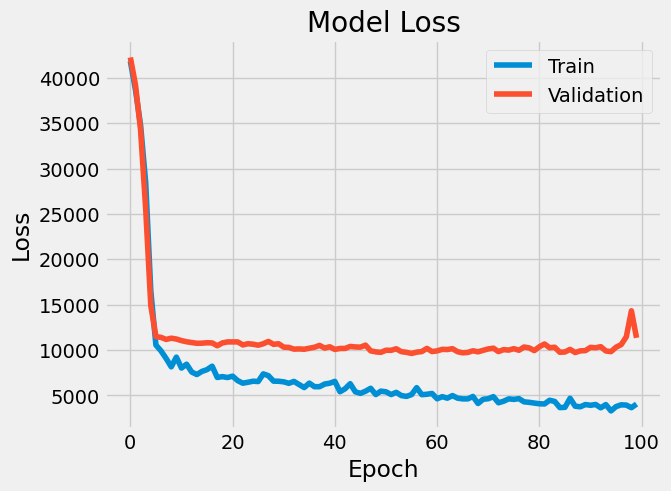

In [112]:
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()


In [113]:
predictions = model.predict(X_test_monthly)


4/4 [==============================] - 0s 4ms/step


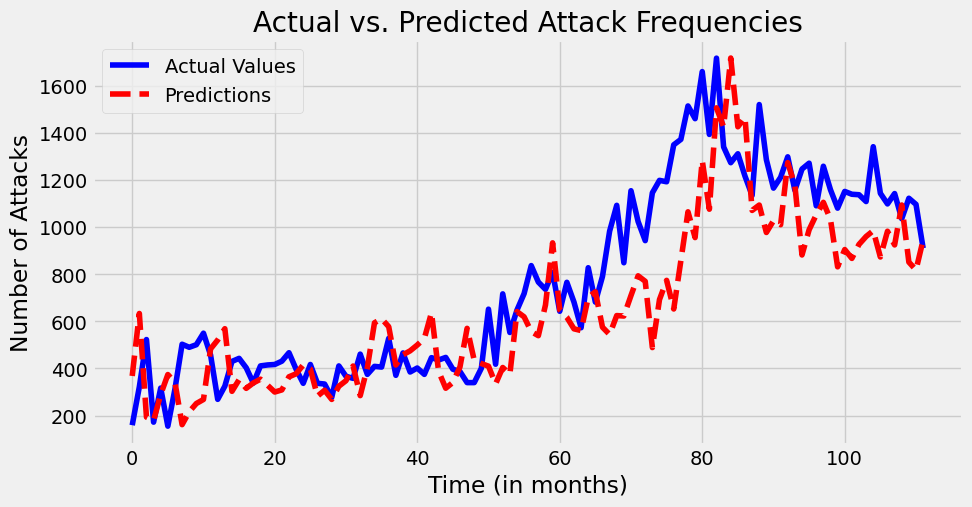

In [114]:

predictions = predictions.flatten()

plt.figure(figsize=(10, 5))
plt.plot(y_test_monthly, label='Actual Values', color='blue')
plt.plot(predictions, label='Predictions', color='red', linestyle='--')
plt.title('Actual vs. Predicted Attack Frequencies')
plt.xlabel('Time (in months)')
plt.ylabel('Number of Attacks')
plt.legend()
plt.show()


In [115]:
from keras.layers import GRU
from keras.regularizers import l1_l2
from keras.callbacks import EarlyStopping

model2 = Sequential([
    GRU(100, activation='relu', input_shape=(X_train_monthly.shape[1], X_train_monthly.shape[2]), return_sequences=True),
    Dropout(0.2),
    GRU(100, activation='relu', return_sequences=False),
    Dropout(0.2),
    Dense(1, kernel_regularizer=l1_l2(l1=0.01, l2=0.01))
])

optimizer = Adam(learning_rate=0.001)

model2.compile(optimizer=optimizer, loss='mse')

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history2 = model2.fit(
    X_train_monthly, y_train_monthly,
    epochs=100,
    batch_size=16,
    validation_split=0.1,
    verbose=2,
    callbacks=[early_stopping]
)

test_loss2 = model2.evaluate(X_test_monthly, y_test_monthly)
print(f'Test Loss: {test_loss2}')


Epoch 1/100
26/26 - 3s - loss: 26655.5254 - val_loss: 9921.1250 - 3s/epoch - 121ms/step
Epoch 2/100
26/26 - 0s - loss: 5101.8745 - val_loss: 11420.0293 - 198ms/epoch - 8ms/step
Epoch 3/100
26/26 - 0s - loss: 4890.5098 - val_loss: 10660.2148 - 187ms/epoch - 7ms/step
Epoch 4/100
26/26 - 0s - loss: 4452.1196 - val_loss: 10850.9570 - 209ms/epoch - 8ms/step
Epoch 5/100
26/26 - 0s - loss: 4006.7681 - val_loss: 11635.2812 - 171ms/epoch - 7ms/step
Epoch 6/100
26/26 - 0s - loss: 4579.1162 - val_loss: 10794.5400 - 175ms/epoch - 7ms/step
Epoch 7/100
26/26 - 0s - loss: 4627.2129 - val_loss: 11079.8545 - 188ms/epoch - 7ms/step
Epoch 8/100
26/26 - 0s - loss: 4614.0532 - val_loss: 11052.8711 - 235ms/epoch - 9ms/step
Epoch 9/100
26/26 - 0s - loss: 4817.7817 - val_loss: 10995.7041 - 287ms/epoch - 11ms/step
Epoch 10/100
26/26 - 0s - loss: 4108.9810 - val_loss: 11089.2637 - 279ms/epoch - 11ms/step
Epoch 11/100
26/26 - 0s - loss: 4050.7349 - val_loss: 11281.9805 - 285ms/epoch - 11ms/step
4/4 [============

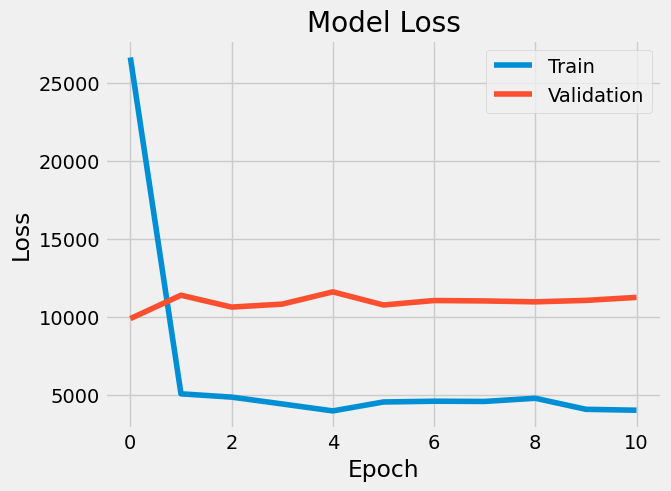

In [116]:
plt.plot(history2.history['loss'], label='Train')
plt.plot(history2.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

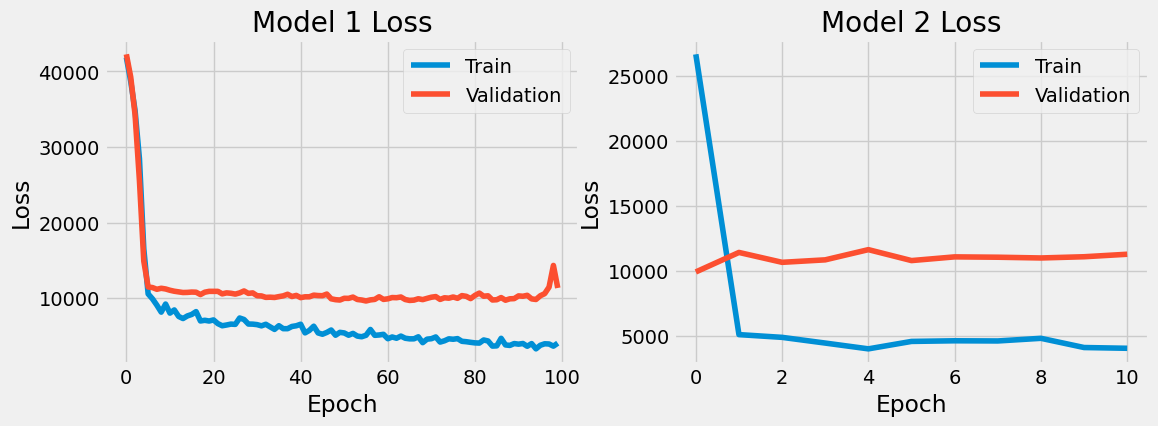

In [133]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(history.history['loss'], label='Train')
ax1.plot(history.history['val_loss'], label='Validation')
ax1.set_title('Model 1 Loss')
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')
ax1.legend(loc='upper right')

ax2.plot(history2.history['loss'], label='Train')
ax2.plot(history2.history['val_loss'], label='Validation')
ax2.set_title('Model 2 Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(loc='upper right')

plt.show()

4/4 [==============================] - 0s 4ms/step


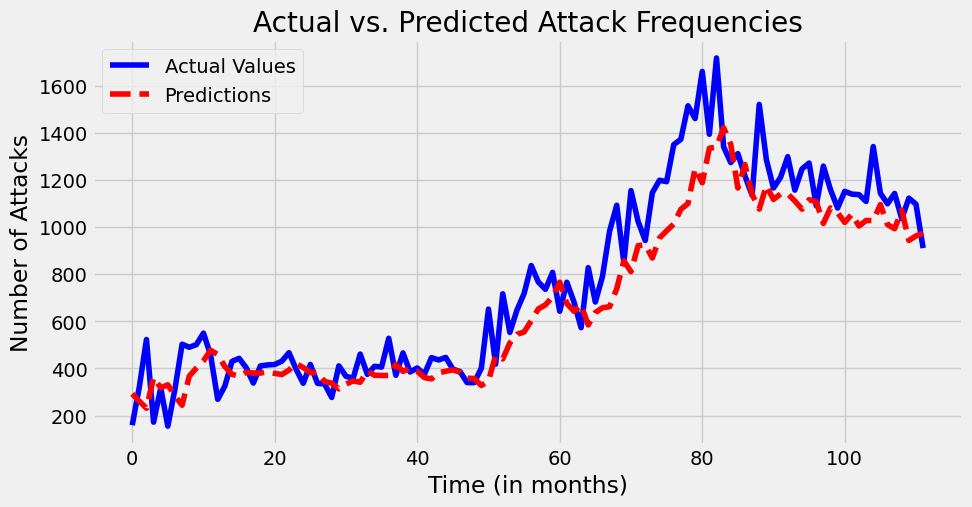

In [117]:
predictions2 = model2.predict(X_test_monthly)

predictions2 = predictions2.flatten()

plt.figure(figsize=(10, 5))
plt.plot(y_test_monthly, label='Actual Values', color='blue')
plt.plot(predictions2, label='Predictions', color='red', linestyle='--')
plt.title('Actual vs. Predicted Attack Frequencies')
plt.xlabel('Time (in months)')
plt.ylabel('Number of Attacks')
plt.legend()
plt.show()

In [118]:
from keras.layers import GRU
from keras.regularizers import l1_l2
from keras.callbacks import EarlyStopping

model3 = Sequential([
    GRU(100, activation='relu', input_shape=(X_train_weekly.shape[1], X_train_weekly.shape[2]), return_sequences=True),
    Dropout(0.2),
    GRU(100, activation='relu', return_sequences=False),
    Dropout(0.2),
    Dense(1, kernel_regularizer=l1_l2(l1=0.01, l2=0.01))
])

optimizer = Adam(learning_rate=0.001)

model3.compile(optimizer=optimizer, loss='mse')

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history3 = model3.fit(
    X_train_weekly, y_train_weekly,
    epochs=100,
    batch_size=16,
    validation_split=0.1,
    verbose=2,
    callbacks=[early_stopping]
)

test_loss3 = model3.evaluate(X_test_weekly, y_test_weekly)
print(f'Test Loss: {test_loss3}')


Epoch 1/100
110/110 - 4s - loss: 448.6299 - val_loss: 735.6390 - 4s/epoch - 40ms/step
Epoch 2/100
110/110 - 1s - loss: 293.7131 - val_loss: 719.9753 - 1s/epoch - 13ms/step
Epoch 3/100
110/110 - 1s - loss: 293.7454 - val_loss: 707.1847 - 1s/epoch - 13ms/step
Epoch 4/100
110/110 - 2s - loss: 269.1102 - val_loss: 699.6941 - 2s/epoch - 18ms/step
Epoch 5/100
110/110 - 2s - loss: 266.4878 - val_loss: 688.4792 - 2s/epoch - 21ms/step
Epoch 6/100
110/110 - 1s - loss: 257.2520 - val_loss: 714.6745 - 1s/epoch - 13ms/step
Epoch 7/100
110/110 - 1s - loss: 247.3555 - val_loss: 709.1081 - 1s/epoch - 13ms/step
Epoch 8/100
110/110 - 1s - loss: 251.3898 - val_loss: 688.5660 - 1s/epoch - 13ms/step
Epoch 9/100
110/110 - 1s - loss: 239.4111 - val_loss: 701.0419 - 1s/epoch - 13ms/step
Epoch 10/100
110/110 - 1s - loss: 241.2987 - val_loss: 688.8571 - 1s/epoch - 13ms/step
Epoch 11/100
110/110 - 1s - loss: 230.2058 - val_loss: 698.4349 - 1s/epoch - 13ms/step
Epoch 12/100
110/110 - 2s - loss: 218.4731 - val_los

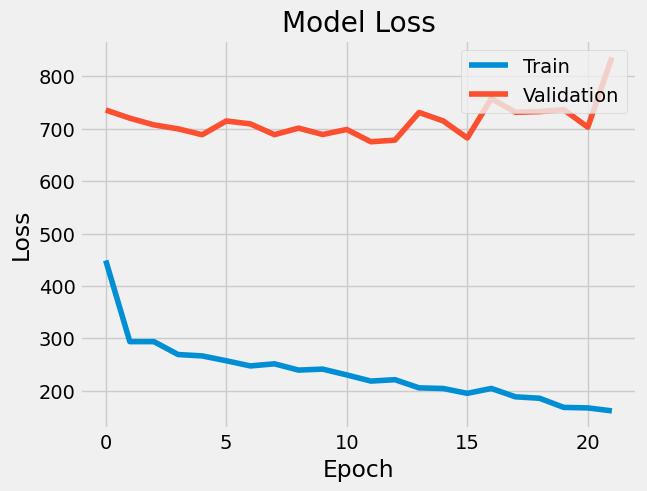

In [119]:
plt.plot(history3.history['loss'], label='Train')
plt.plot(history3.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

16/16 [==============================] - 0s 6ms/step


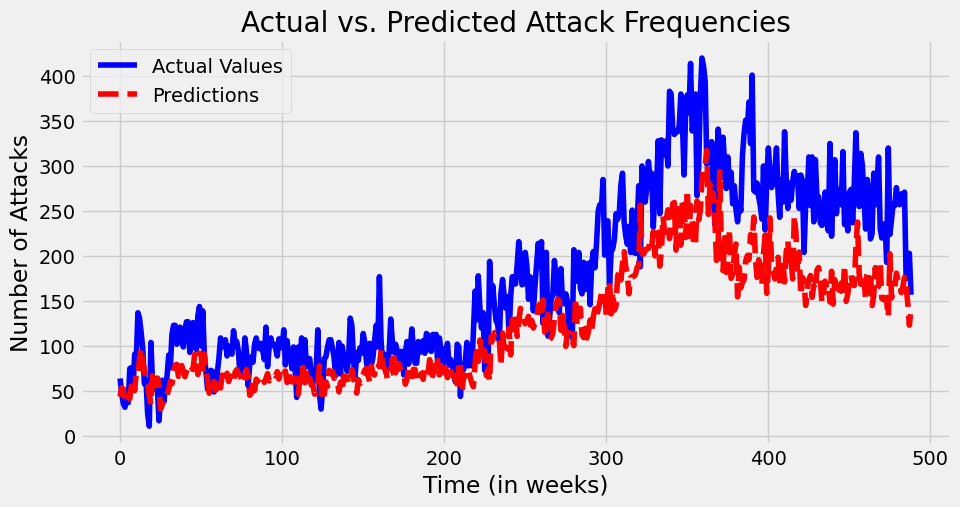

In [120]:
predictions3 = model3.predict(X_test_weekly)

predictions3 = predictions3.flatten()

plt.figure(figsize=(10, 5))
plt.plot(y_test_weekly, label='Actual Values', color='blue')
plt.plot(predictions3, label='Predictions', color='red', linestyle='--')
plt.title('Actual vs. Predicted Attack Frequencies')
plt.xlabel('Time (in weeks)')
plt.ylabel('Number of Attacks')
plt.legend()

In [121]:
tdf.columns.to_list()

['Year',
 'Month',
 'Day',
 'Date',
 'Country',
 'CountryCode',
 'Region',
 'city',
 'latitude',
 'longitude',
 'AttackType',
 'Target_type',
 'Group',
 'Killed',
 'Wounded',
 'Weapon_type',
 'casualties',
 'IsHoliday',
 'suicide',
 'claimed',
 'success',
 'DaysSinceLatt']

In [122]:
from keras.optimizers import Adam

model4 = Sequential([
    LSTM(64, activation='relu', input_shape=(X_train_weekly.shape[1], X_train_weekly.shape[2]), return_sequences=True),
    Dropout(0.3),
    LSTM(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='linear')
])

optimizer = Adam(learning_rate=0.0001)

model4.compile(optimizer=optimizer, loss='mse')

In [123]:
history4 = model4.fit(X_train_weekly, y_train_weekly, epochs=100, batch_size=16, validation_split=0.1, verbose=2)
test_loss4 = model4.evaluate(X_test_weekly, y_test_weekly)
print('Test Loss:', test_loss4)


Epoch 1/100
110/110 - 5s - loss: 2575.4226 - val_loss: 1206.8770 - 5s/epoch - 50ms/step
Epoch 2/100
110/110 - 2s - loss: 1296.0519 - val_loss: 1142.4065 - 2s/epoch - 19ms/step
Epoch 3/100
110/110 - 1s - loss: 1007.7842 - val_loss: 1091.9701 - 1s/epoch - 13ms/step
Epoch 4/100
110/110 - 1s - loss: 852.8459 - val_loss: 1064.7173 - 1s/epoch - 11ms/step
Epoch 5/100
110/110 - 1s - loss: 776.7069 - val_loss: 1079.1030 - 1s/epoch - 11ms/step
Epoch 6/100
110/110 - 1s - loss: 761.4398 - val_loss: 981.2088 - 1s/epoch - 10ms/step
Epoch 7/100
110/110 - 1s - loss: 675.1249 - val_loss: 943.7590 - 1s/epoch - 10ms/step
Epoch 8/100
110/110 - 1s - loss: 594.5805 - val_loss: 915.5050 - 1s/epoch - 11ms/step
Epoch 9/100
110/110 - 1s - loss: 625.1336 - val_loss: 868.8394 - 1s/epoch - 11ms/step
Epoch 10/100
110/110 - 1s - loss: 574.7557 - val_loss: 865.6123 - 1s/epoch - 11ms/step
Epoch 11/100
110/110 - 1s - loss: 510.0729 - val_loss: 889.2360 - 1s/epoch - 10ms/step
Epoch 12/100
110/110 - 2s - loss: 449.9545 -

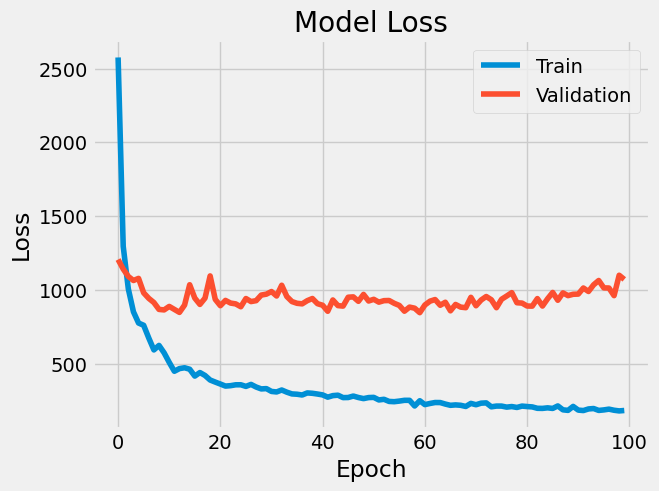

In [134]:
# Plot training & validation loss values
plt.plot(history4.history['loss'], label='Train')
plt.plot(history4.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

16/16 [==============================] - 0s 4ms/step


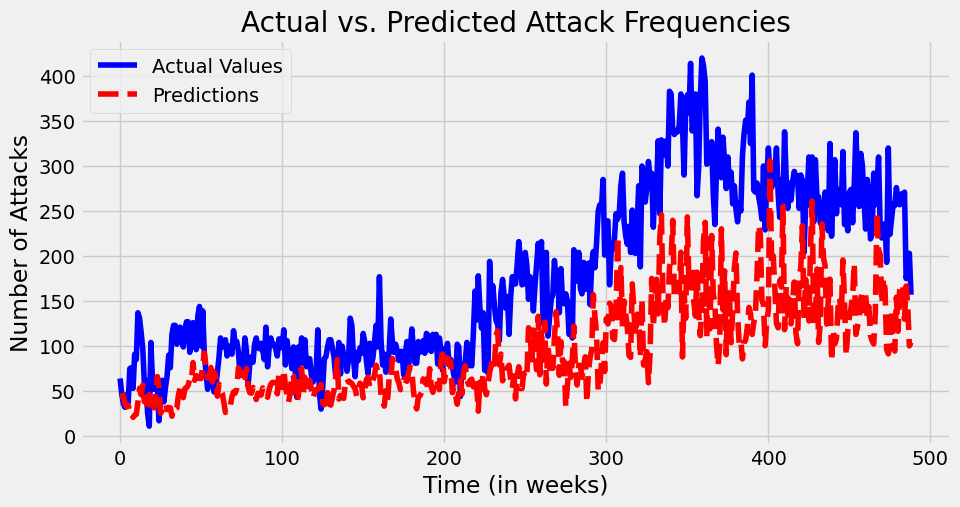

In [124]:
predictions4 = model4.predict(X_test_weekly)

predictions4 = predictions4.flatten()

plt.figure(figsize=(10, 5))
plt.plot(y_test_weekly, label='Actual Values', color='blue')
plt.plot(predictions4, label='Predictions', color='red', linestyle='--')
plt.title('Actual vs. Predicted Attack Frequencies')
plt.xlabel('Time (in weeks)')
plt.ylabel('Number of Attacks')
plt.legend()

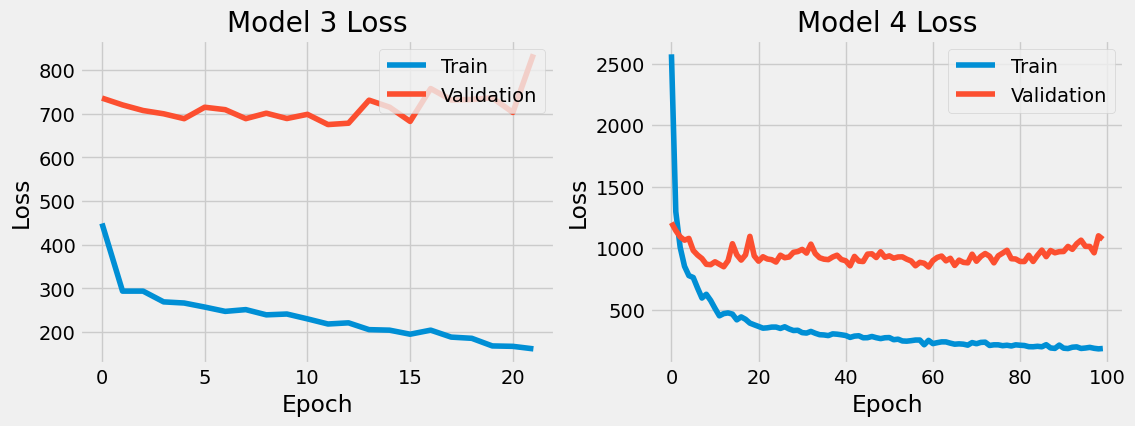

In [136]:
fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(12, 4))

ax3.plot(history3.history['loss'], label='Train')
ax3.plot(history3.history['val_loss'], label='Validation')
ax3.set_title('Model 3 Loss')
ax3.set_ylabel('Loss')
ax3.set_xlabel('Epoch')
ax3.legend(loc='upper right')

ax4.plot(history4.history['loss'], label='Train')
ax4.plot(history4.history['val_loss'], label='Validation')
ax4.set_title('Model 4 Loss')
ax4.set_ylabel('Loss')
ax4.set_xlabel('Epoch')
ax4.legend(loc='upper right')

plt.show()

In [130]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mae_model = mean_squared_error(y_test_monthly, predictions, squared=False)
print(f'Mean Absolute Error 1: {mae_model}')

rmse_model = sqrt(mae_model)
print(f'Root Mean Squared Error 1: {rmse_model}')


mae_model2 = mean_squared_error(y_test_monthly, predictions2, squared=False)
print(f'Mean Absolute Error 2: {mae_model2}')

rmse_model2 = sqrt(mae_model2)
print(f'Root Mean Squared Error 2: {rmse_model2}')

mae_model3 = mean_squared_error(y_test_weekly, predictions3, squared=False)
print(f'Mean Absolute Error 3: {mae_model3}')

rmse_model3 = sqrt(mae_model3)
print(f'Root Mean Squared Error 3: {rmse_model3}')

mae_model4 = mean_squared_error(y_test_weekly, predictions4, squared=False)
print(f'Mean Absolute Error 4: {mae_model4}')

rmse_model4 = sqrt(mae_model4)
print(f'Root Mean Squared Error 4: {rmse_model4}')


Mean Absolute Error 1: 236.27740958334158
Root Mean Squared Error 1: 15.371317756891944
Mean Absolute Error 2: 158.4214244752761
Root Mean Squared Error 2: 12.586557292416227
Mean Absolute Error 3: 67.63009746066442
Root Mean Squared Error 3: 8.223752030591902
Mean Absolute Error 4: 102.20967218980982
Root Mean Squared Error 4: 10.109879929544654


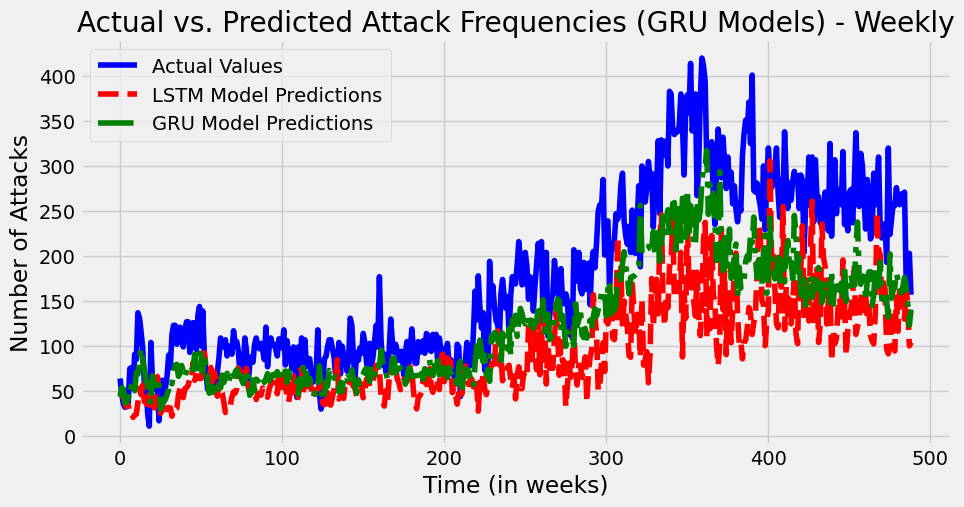

In [142]:
plt.figure(figsize=(10, 5))
plt.plot(y_test_weekly, label='Actual Values', color='blue')
plt.plot(predictions4, label='LSTM Model Predictions', color='red', linestyle='--')
plt.plot(predictions3, label='GRU Model Predictions', color='green', linestyle='-.')
plt.title('Actual vs. Predicted Attack Frequencies (GRU Models) - Weekly')
plt.xlabel('Time (in weeks)')
plt.ylabel('Number of Attacks')
plt.legend()
plt.show()

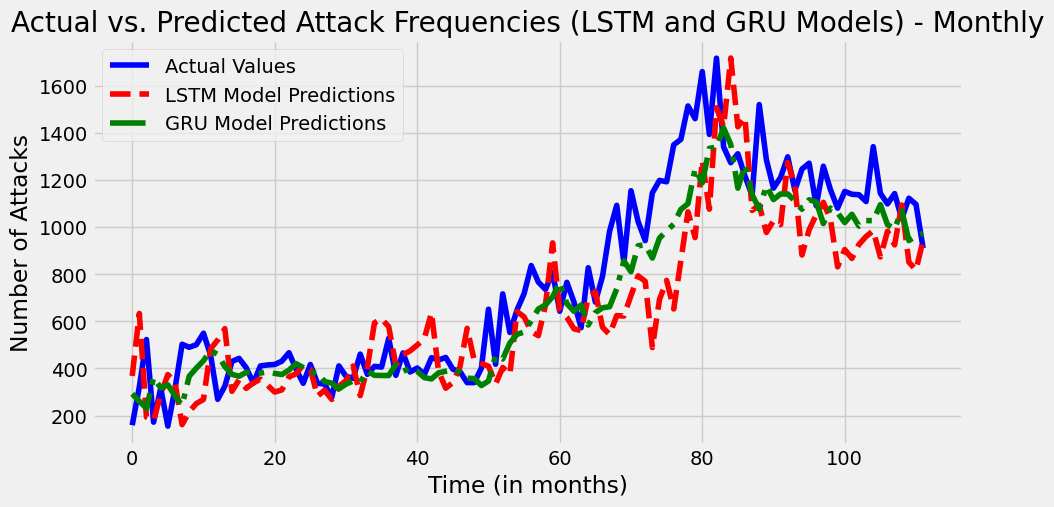

In [141]:
plt.figure(figsize=(10, 5))
plt.plot(y_test_monthly, label='Actual Values', color='blue')
plt.plot(predictions, label='LSTM Model Predictions', color='red', linestyle='--')
plt.plot(predictions2, label='GRU Model Predictions', color='green', linestyle='-.')
plt.title('Actual vs. Predicted Attack Frequencies (LSTM and GRU Models) - Monthly')
plt.xlabel('Time (in months)')
plt.ylabel('Number of Attacks')
plt.legend()
plt.show()

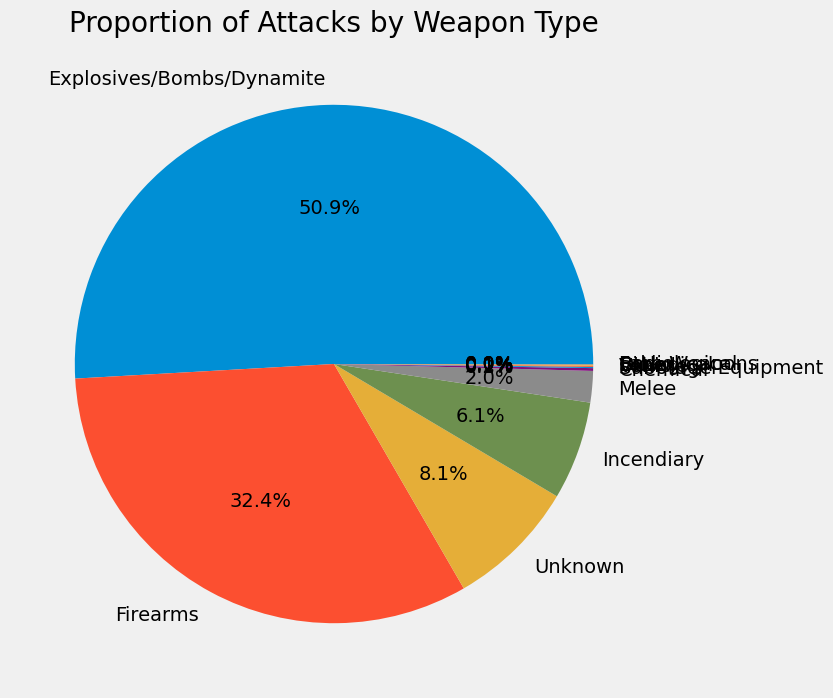

In [143]:
weapon_types = tdf['Weapon_type'].value_counts()

plt.figure(figsize=(18, 8))
plt.pie(weapon_types, labels=weapon_types.index, autopct='%1.1f%%')
plt.title('Proportion of Attacks by Weapon Type')
plt.show()


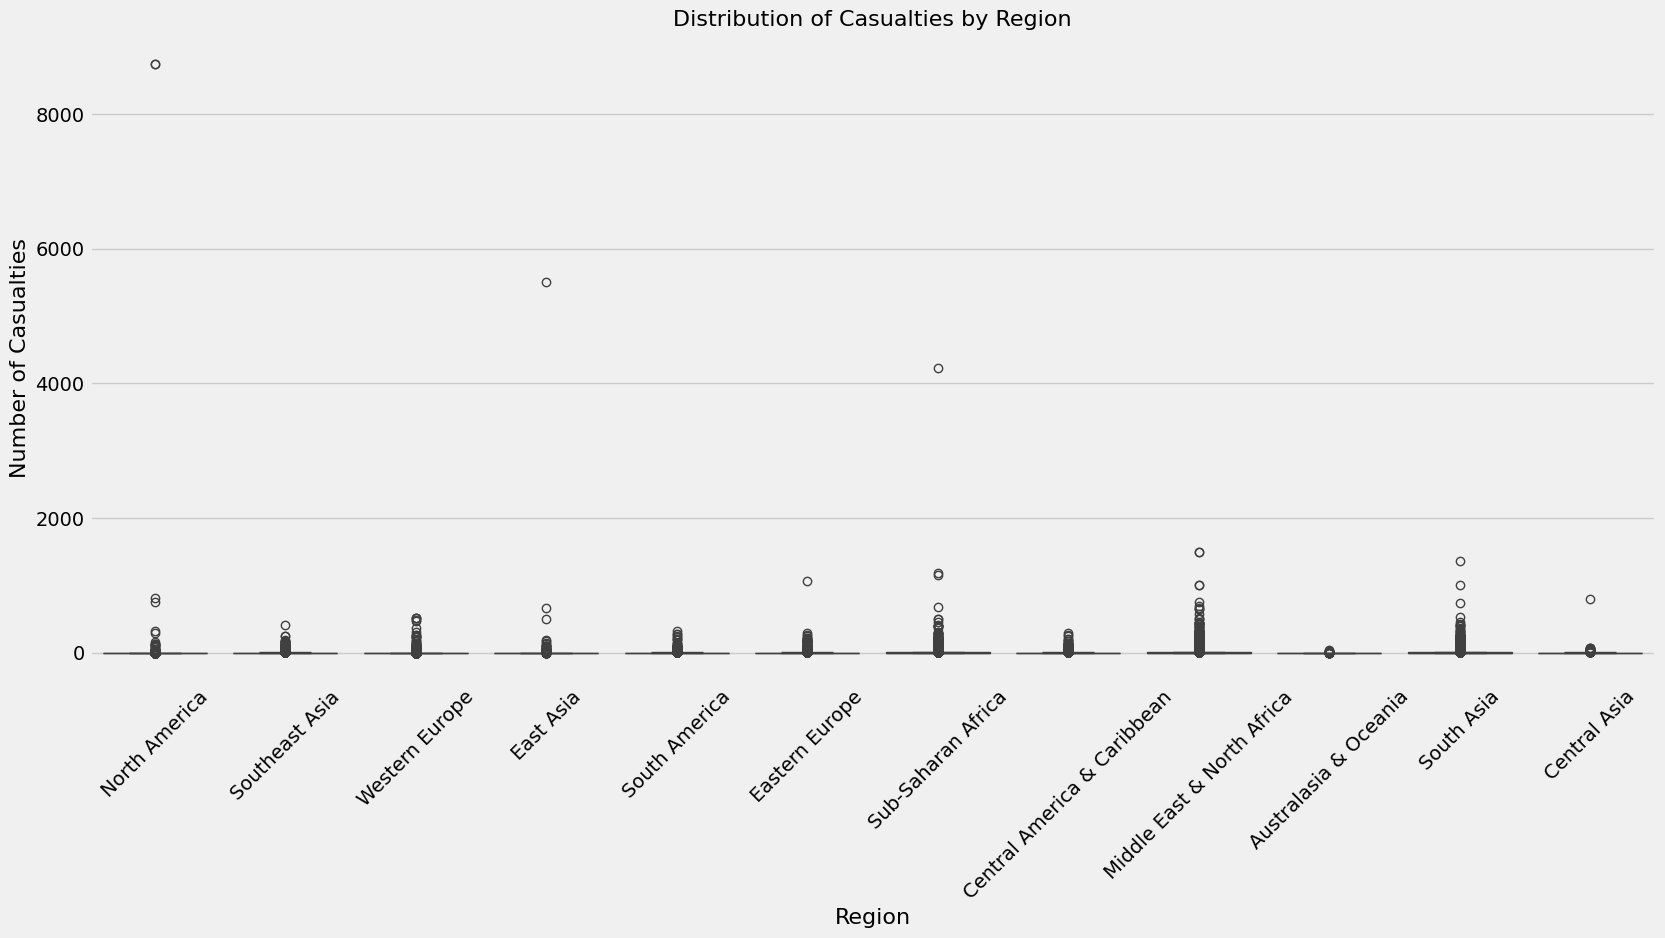

In [144]:
plt.figure(figsize=(18, 8))

sns.boxplot(
    data=tdf,
    x="Region",
    y="casualties",
)

plt.title("Distribution of Casualties by Region", fontsize=16)
plt.xlabel("Region", fontsize=16)
plt.ylabel("Number of Casualties", fontsize=16)

plt.xticks(rotation=45)

plt.show()


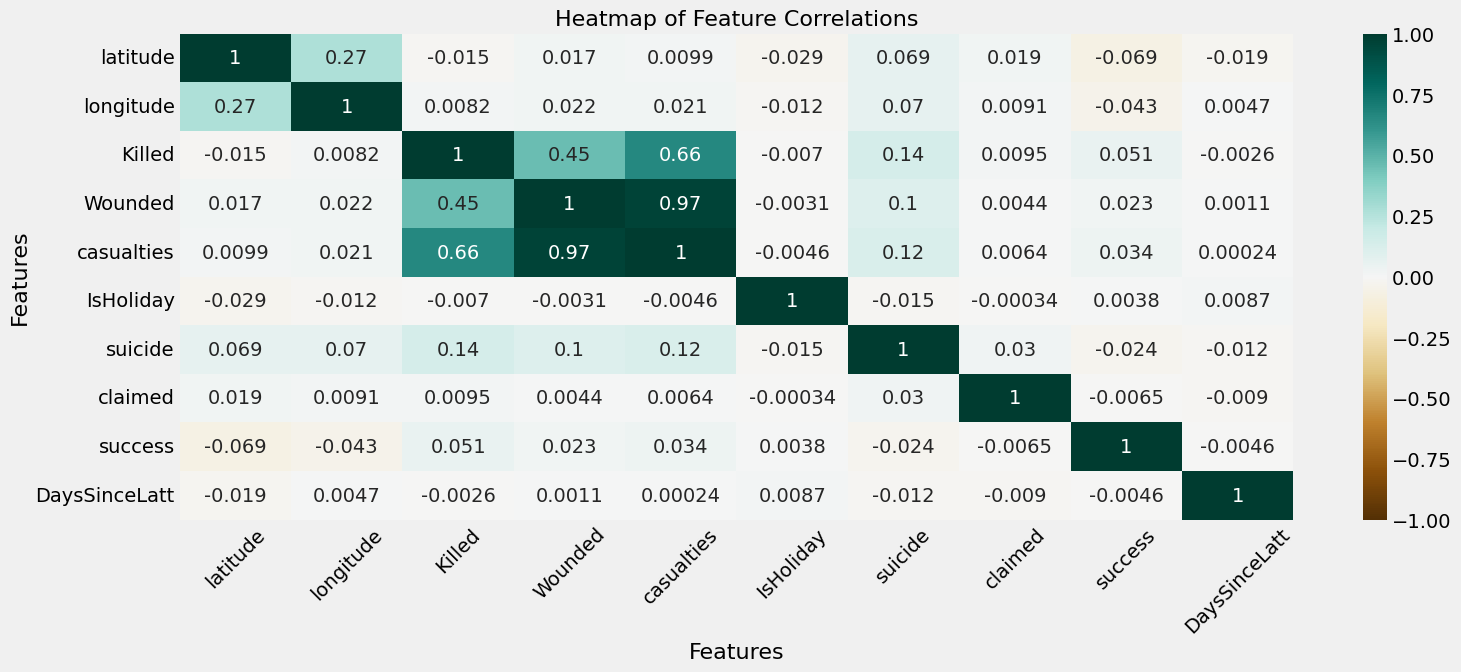

In [145]:
numerical_cols = tdf.select_dtypes(include=['int64', 'float64']).columns.tolist()

correlation_matrix = tdf[numerical_cols].corr()

plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(correlation_matrix, vmin=-1, vmax=1, annot=True, cmap='BrBG')

plt.title('Heatmap of Feature Correlations', fontsize=16)
plt.xlabel('Features', fontsize=16)
plt.ylabel('Features', fontsize=16)

plt.xticks(rotation=45)

plt.show()

In [129]:
import plotly.express as px

fig = px.treemap(tdf, path=['Country'], values='casualties',
                 title='Treemap of Casualties by Country')


fig.show()